In [1]:
from langgraph.graph import StateGraph, END
from langchain_openai import AzureChatOpenAI
from typing import TypedDict, Optional
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [2]:
# Configure ChatOpenAI for Azure OpenAI
deployment_name = "gpt-4o-mini"  # Replace with your actual deployment name

openai_llm = AzureChatOpenAI(
    azure_deployment=deployment_name,
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    temperature=0.7,
    model_name=deployment_name,
    max_retries=3,
    request_timeout=120,
    max_tokens=1024,
    top_p=0.95   
)

In [3]:
class QAState(TypedDict):
    question: Optional[str] 
    context: Optional[str]    
    answer: Optional[str]

Nodes: 
- input_node (get question from state, if it's not defined return "valid" = False and "error" ) -> this is the entry point.
- context_provider_node (check if the question is in the context. For related questions provide the context, for not related question, context will be `null`)
- answer_node (uses the context to answer the question - if the context is null -> generic answer)

Edges:
- from input to context_provider
- from context_provider to answer
- from answer to END


Defining the nodes:


In [30]:
def input_node(state: QAState) -> QAState:
    # get question from state, if it's not defined return "valid" = False and "error" 

    question = state.get("question", None).strip()
    return {"question": question}

def context_provider_node(state: QAState) -> QAState:
    # check if the question is in the context. For related questions provide the context, for
    # not related question, context will be `null`
    question = state.get("question", "").lower()
    if "langgraph" in question:
        context = "Langgraph is a Python library for building state machines and workflows."    
        return {"context": context}
    
    # For other questions, return null context
    return {"context": None}

def answer_node(state: QAState) -> QAState:
    # uses the context to answer the question - if the context is null -> generic answer
    question = state.get("question", "")
    context = state.get("context", None)

    if not question:
        return {"answer": "The question is empty. Please provide a valid question."}
    
    if context:
        prompt = f"Based on the following context, answer the question:\nContext: {context}\nQuestion: {question}\nAnswer:"
    else:
        return {"answer": "I don't have enough information to answer that question."}
    
    response = openai_llm.invoke(prompt)
    answer = response.content.strip()
    
    return {"answer": answer}
        


In [11]:
# state = QAState(question="What is Langgraph?", 
#         context="", 
#         answer=None)
# answer_node(state)

# state = QAState(question="What is Langgraph?", 
#         context="Langgraph is a Python library for building state machines and workflows.", 
#         answer=None)
# answer_node(state)

In [31]:
# Create an instance of StateGraph with the GraphState structure
wf = StateGraph(QAState)

wf.add_node("Input", input_node)
wf.add_node("ContextProvider", context_provider_node)
wf.add_node("Answer", answer_node)

wf.add_edge("Input", "ContextProvider")
wf.add_edge("ContextProvider", "Answer")
wf.add_edge("Answer", END)

wf.set_entry_point("Input")
app = wf.compile()

In [ ]:
state = QAState(question="What is Langgraph?", 
        context=None ,
        answer=None)
app.invoke(state)


{'question': '',
 'context': None,
 'answer': 'The question is empty. Please provide a valid question.'}

In [ ]:
# %pip install grandalf

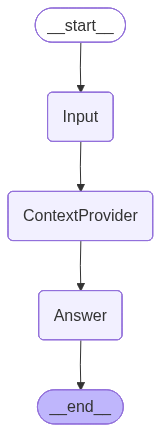

In [34]:
# Create a visual graph using grandalf

# Use LangGraph's built-in visualization with grandalf
from IPython.display import Image, display

# Get the graph visualization using grandalf
img = app.get_graph().draw_mermaid_png()
display(Image(img))
